# Importando datasets de radares

In [59]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [60]:
# Carregar o shapefile (substitua pelo caminho do seu arquivo .shp)
gdf = gpd.read_file("shapefiles/rodovias_sul.shp")

# Mostrar as primeiras linhas da tabela de atributos
gdf.head()


,compriment,CD_MUN,NM_MUN,CD_RGI,NM_RGI,CD_RGINT,NM_RGINT,CD_UF,NM_UF,SIGLA_UF,CD_REGIA,NM_REGIA,SIGLA_RG,CD_CONCU,NM_CONCU,AREA_KM2,geometry
0,4070.683523,4208203,Itajaí,420020,Itajaí,4207,Blumenau,42,Santa Catarina,SC,4,Sul,S,4208203,Itajaí - Balneário Camboriú/SC,289.215,"LINESTRING (-48.71387 -26.90829, -48.71278 -26..."
1,2885.021693,4208203,Itajaí,420020,Itajaí,4207,Blumenau,42,Santa Catarina,SC,4,Sul,S,4208203,Itajaí - Balneário Camboriú/SC,289.215,"LINESTRING (-48.68684 -26.88814, -48.68605 -26..."
2,6719.245321,4208203,Itajaí,420020,Itajaí,4207,Blumenau,42,Santa Catarina,SC,4,Sul,S,4208203,Itajaí - Balneário Camboriú/SC,289.215,"LINESTRING (-48.7196 -26.84443, -48.71961 -26...."
3,3793.880959,4208203,Itajaí,420020,Itajaí,4207,Blumenau,42,Santa Catarina,SC,4,Sul,S,4208203,Itajaí - Balneário Camboriú/SC,289.215,"LINESTRING (-48.72149 -26.89, -48.72147 -26.89..."
4,2725.480633,4208203,Itajaí,420020,Itajaí,4207,Blumenau,42,Santa Catarina,SC,4,Sul,S,4208203,Itajaí - Balneário Camboriú/SC,289.215,"LINESTRING (-48.70962 -26.91847, -48.70958 -26..."


In [61]:
gdf.shape

(2473, 17)

In [62]:
gdf.columns

Index(['compriment', 'CD_MUN', 'NM_MUN', 'CD_RGI', 'NM_RGI', 'CD_RGINT',
       'NM_RGINT', 'CD_UF', 'NM_UF', 'SIGLA_UF', 'CD_REGIA', 'NM_REGIA',
       'SIGLA_RG', 'CD_CONCU', 'NM_CONCU', 'AREA_KM2', 'geometry'],
      dtype='object')

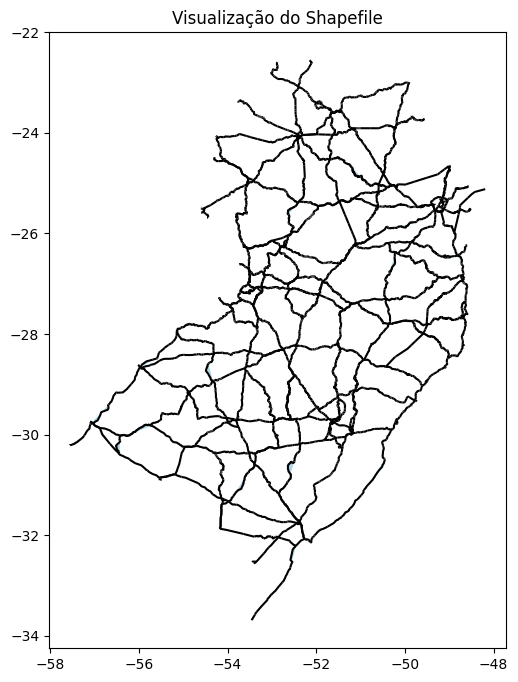

In [63]:
# Plotar o shapefile
gdf.plot(figsize=(10, 8), edgecolor="black", facecolor="lightblue")
plt.title("Visualização do Shapefile")
plt.show()

C:\Users\adria\AppData\Local\Temp\ipykernel_14712\3060850291.py:2: DtypeWarning: Columns (25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ocorrencia = pd.read_csv("../dados/acidentes/por ocorrencia/datatran_agrupado.csv", sep=",")


Total de acidentes relacionados à velocidade: 24252


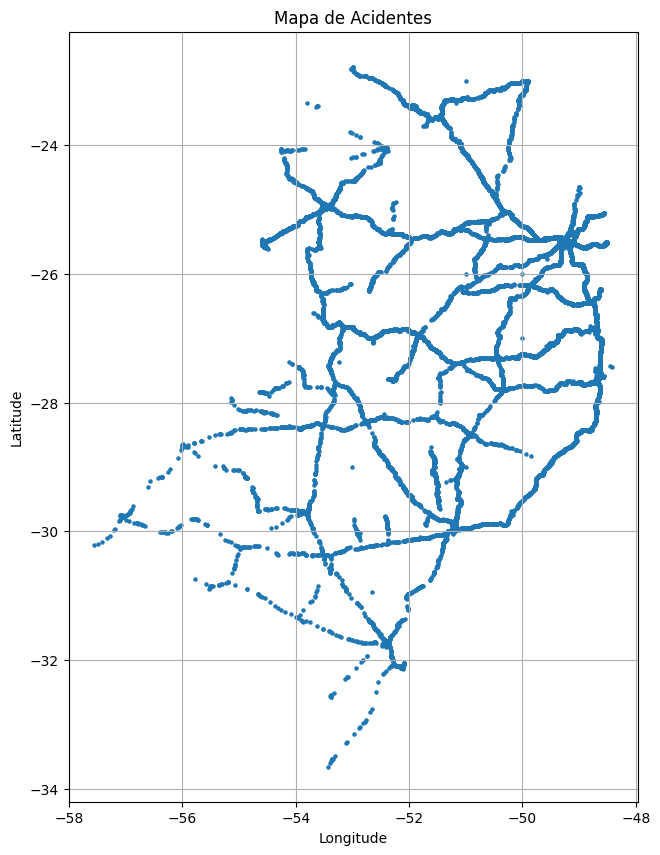

In [64]:
ufs = ['RS', 'SC', 'PR']
df_ocorrencia = pd.read_csv("../dados/acidentes/por ocorrencia/datatran_agrupado.csv", sep=",")
df_ocorrencia = df_ocorrencia[df_ocorrencia['uf'].isin(ufs)]
# Lista de causas que poderiam ser evitadas com radar
causas_relacionadas_velocidade = [
    "Velocidade Incompatível",
    "Participar de racha",
    "Condutor deixou de manter distância do veículo da frente",
    "Reação tardia ou ineficiente do condutor",
    "Transitar na contramão",
    "Ultrapassagem Indevida",
    "Frear bruscamente",
    "Condutor usando celular",
    "Transitar no acostamento",
    "Transitar no Acostamento"
]

# Filtrar dataframe
df_ocorrencia = df_ocorrencia[
    df_ocorrencia['causa_acidente'].isin(causas_relacionadas_velocidade)
]

# Visualizar
print(f"Total de acidentes relacionados à velocidade: {len(df_ocorrencia)}")
df_ocorrencia['latitude'] = df_ocorrencia['latitude'].str.replace(',', '.')
df_ocorrencia['longitude'] = df_ocorrencia['longitude'].str.replace(',', '.')

df_ocorrencia = df_ocorrencia.dropna(subset=['latitude'])
df_ocorrencia = df_ocorrencia.dropna(subset=['longitude'])

df_ocorrencia['latitude'] = pd.to_numeric(df_ocorrencia['latitude'], errors='coerce')
df_ocorrencia['longitude'] = pd.to_numeric(df_ocorrencia['longitude'], errors='coerce')
df_ocorrencia.head()
acidentes = gpd.GeoDataFrame(
    df_ocorrencia,
    geometry=gpd.points_from_xy(df_ocorrencia['longitude'], df_ocorrencia['latitude']),
    crs="EPSG:4326"
)
# Assumindo que 'acidentes' já é um GeoDataFrame com geometria definida
acidentes.plot(figsize=(10, 10), markersize=5)

plt.title('Mapa de Acidentes')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

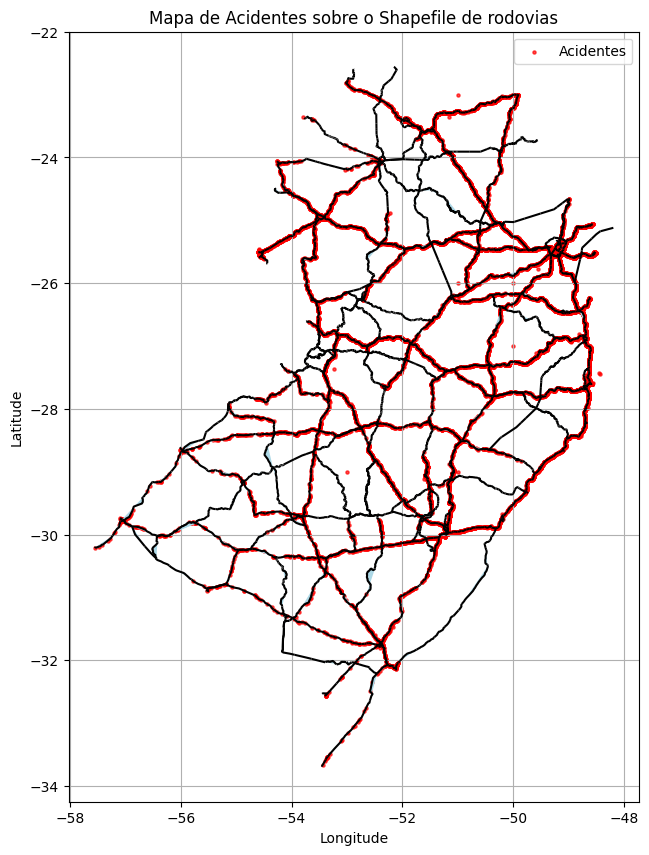

In [65]:
# Cria a figura e os eixos
fig, ax = plt.subplots(figsize=(12, 10))

# Plota o shapefile como base (rodovias, municípios, etc.)
gdf.plot(ax=ax, edgecolor="black", facecolor="lightblue")

# Plota os acidentes por cima
acidentes.plot(ax=ax, markersize=5, color="red", alpha=0.7, label="Acidentes")

# Ajustes do mapa
plt.title("Mapa de Acidentes sobre o Shapefile de rodovias")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.legend()
plt.show()

In [66]:
gdf = gdf.reset_index(drop=True)  # garante índice único
gdf['trecho_id'] = gdf.index       # cria ID único para cada linha

In [68]:
# Reprojetar ambos para o mesmo CRS
gdf = gdf.to_crs(epsg=31982)
acidentes = acidentes.to_crs(epsg=31982)

# Criar buffer de 100m para garantir que pontos próximos sejam capturados
gdf_buffer = gdf.copy()
gdf_buffer['geometry'] = gdf_buffer.geometry.buffer(100)

# Fazer o join espacial
acidentes_rodovia = gpd.sjoin(
    acidentes, gdf_buffer, 
    how='left', predicate='intersects'
)


In [69]:
# Resetar índice para evitar problemas
acidentes_rodovia = acidentes_rodovia.reset_index()

# Pegar o primeiro trecho para cada acidente (assumindo que 'index' do acidente é único)
acidentes_unicos = acidentes_rodovia.groupby('index').first().reset_index()

# Adiciona coluna de trecho ao GeoDataFrame original
acidentes['trecho_id'] = acidentes_unicos['trecho_id'].values


In [70]:
# Apenas usar acidentes_rodovia como base final
# Cada linha representa um acidente em um trecho específico
# Para contagem de acidentes por trecho, use:
acidentes_por_trecho = acidentes_rodovia.groupby('trecho_id').size().reset_index(name='qtd_acidentes')


In [71]:
acidentes_por_trecho.head()

,trecho_id,qtd_acidentes
0,2.0,127
1,3.0,113
2,4.0,68
3,5.0,87
4,6.0,1


In [72]:
# Merge para adicionar qtd_acidentes ao GeoDataFrame de rodovias
gdf_acidentes = gdf.merge(acidentes_por_trecho, on="trecho_id", how="left")

# Preenche trechos sem acidentes com 0
gdf_acidentes["qtd_acidentes"] = gdf_acidentes["qtd_acidentes"].fillna(0).astype(int)


In [93]:
gdf_acidentes.head()

,compriment,CD_MUN,NM_MUN,CD_RGI,NM_RGI,CD_RGINT,NM_RGINT,CD_UF,NM_UF,SIGLA_UF,CD_REGIA,NM_REGIA,SIGLA_RG,CD_CONCU,NM_CONCU,AREA_KM2,geometry,trecho_id,qtd_acidentes
0,4070.683523,4208203,Itajaí,420020,Itajaí,4207,Blumenau,42,Santa Catarina,SC,4,Sul,S,4208203,Itajaí - Balneário Camboriú/SC,289.215,"LINESTRING (727038.55 7021672.274, 727148.094 ...",0,0
1,2885.021693,4208203,Itajaí,420020,Itajaí,4207,Blumenau,42,Santa Catarina,SC,4,Sul,S,4208203,Itajaí - Balneário Camboriú/SC,289.215,"LINESTRING (729764.434 7023855.787, 729842.651...",1,0
2,6719.245321,4208203,Itajaí,420020,Itajaí,4207,Blumenau,42,Santa Catarina,SC,4,Sul,S,4208203,Itajaí - Balneário Camboriú/SC,289.215,"LINESTRING (726596.658 7028757.974, 726595.257...",2,127
3,3793.880959,4208203,Itajaí,420020,Itajaí,4207,Blumenau,42,Santa Catarina,SC,4,Sul,S,4208203,Itajaí - Balneário Camboriú/SC,289.215,"LINESTRING (726318.183 7023712.199, 726319.705...",3,113
4,2725.480633,4208203,Itajaí,420020,Itajaí,4207,Blumenau,42,Santa Catarina,SC,4,Sul,S,4208203,Itajaí - Balneário Camboriú/SC,289.215,"LINESTRING (727440.012 7020536.265, 727444.072...",4,68


In [82]:
gdf_acidentes['qtd_acidentes'] = pd.to_numeric(gdf_acidentes['qtd_acidentes'], errors='coerce')

# 3. (Opcional) Remover linhas onde a conversão falhou, se necessário.
# Se houver valores NaN, a plotagem pode ignorá-los por padrão, mas é uma boa prática
# estar ciente deles.
gdf_acidentes.dropna(subset=['qtd_acidentes'], inplace=True)

# --- Fim do Bloco de Correção ---



In [83]:
gdf_acidentes.head()

,compriment,CD_MUN,NM_MUN,CD_RGI,NM_RGI,CD_RGINT,NM_RGINT,CD_UF,NM_UF,SIGLA_UF,CD_REGIA,NM_REGIA,SIGLA_RG,CD_CONCU,NM_CONCU,AREA_KM2,geometry,trecho_id,qtd_acidentes
0,4070.683523,4208203,Itajaí,420020,Itajaí,4207,Blumenau,42,Santa Catarina,SC,4,Sul,S,4208203,Itajaí - Balneário Camboriú/SC,289.215,"LINESTRING (727038.55 7021672.274, 727148.094 ...",0,0
1,2885.021693,4208203,Itajaí,420020,Itajaí,4207,Blumenau,42,Santa Catarina,SC,4,Sul,S,4208203,Itajaí - Balneário Camboriú/SC,289.215,"LINESTRING (729764.434 7023855.787, 729842.651...",1,0
2,6719.245321,4208203,Itajaí,420020,Itajaí,4207,Blumenau,42,Santa Catarina,SC,4,Sul,S,4208203,Itajaí - Balneário Camboriú/SC,289.215,"LINESTRING (726596.658 7028757.974, 726595.257...",2,127
3,3793.880959,4208203,Itajaí,420020,Itajaí,4207,Blumenau,42,Santa Catarina,SC,4,Sul,S,4208203,Itajaí - Balneário Camboriú/SC,289.215,"LINESTRING (726318.183 7023712.199, 726319.705...",3,113
4,2725.480633,4208203,Itajaí,420020,Itajaí,4207,Blumenau,42,Santa Catarina,SC,4,Sul,S,4208203,Itajaí - Balneário Camboriú/SC,289.215,"LINESTRING (727440.012 7020536.265, 727444.072...",4,68


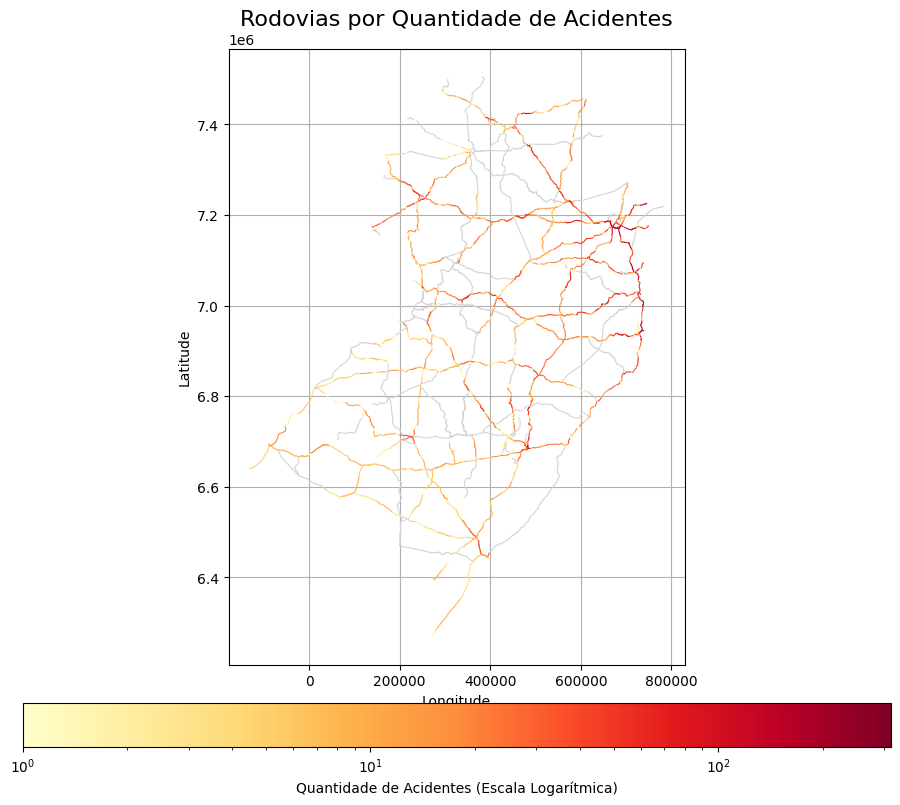

In [96]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import geopandas as gpd

# --- Preparação dos Dados (sem alterações) ---
if "qtd_acidentes" not in gdf_acidentes.columns:
    raise ValueError("A coluna 'qtd_acidentes' não foi encontrada.")
gdf_acidentes['qtd_acidentes'] = pd.to_numeric(gdf_acidentes['qtd_acidentes'], errors='coerce')
gdf_acidentes.dropna(subset=['qtd_acidentes'], inplace=True)

# --- Lógica de Coloração Manual ---
valores = gdf_acidentes['qtd_acidentes']
norm = mcolors.LogNorm(vmin=1, vmax=valores.max())

# ***** ALTERAÇÃO FEITA AQUI *****
# Trocamos 'Reds' por 'YlOrRd' para cores mais vibrantes
cmap = plt.get_cmap('YlOrRd')

cor_cinza_rgba = mcolors.to_rgba('#d3d3d3')
cores = [cmap(norm(valor)) if valor > 0 else cor_cinza_rgba for valor in valores]

# --- Plotagem Direta ---
fig, ax = plt.subplots(figsize=(14, 10))

gdf_acidentes.plot(
    ax=ax,
    color=cores,
    edgecolor='black', # Borda preta para definir bem os trechos
    linewidth=0.8
)

# --- Legenda (Barra de Cores Manual) ---
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8)
cbar.set_label('Quantidade de Acidentes (Escala Logarítmica)')

# --- Finalização do Gráfico ---
ax.set_title("Rodovias por Quantidade de Acidentes", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)

plt.show()


In [98]:
# Certifique-se de que a coluna 'qtd_acidentes' é numérica
gdf_acidentes['qtd_acidentes'] = pd.to_numeric(gdf_acidentes['qtd_acidentes'], errors='coerce')
gdf_acidentes.dropna(subset=['qtd_acidentes'], inplace=True)
gdf_acidentes['qtd_acidentes'] = gdf_acidentes['qtd_acidentes'].astype(int)

# Ordena o GeoDataFrame pela coluna 'qtd_acidentes' em ordem decrescente e mostra as 5 primeiras linhas
gdf_acidentes.sort_values(by='qtd_acidentes', ascending=False).head()


,compriment,CD_MUN,NM_MUN,CD_RGI,NM_RGI,CD_RGINT,NM_RGINT,CD_UF,NM_UF,SIGLA_UF,CD_REGIA,NM_REGIA,SIGLA_RG,CD_CONCU,NM_CONCU,AREA_KM2,geometry,trecho_id,qtd_acidentes
146,4810.424876,4216602,São José,420001,Florianópolis,4201,Florianópolis,42,Santa Catarina,SC,4,Sul,S,4205407,Florianópolis/SC,150.499,"LINESTRING (735283.847 6946313.319, 735273.97 ...",146,313
151,4810.424876,4216602,São José,420001,Florianópolis,4201,Florianópolis,42,Santa Catarina,SC,4,Sul,S,4205407,Florianópolis/SC,150.499,"LINESTRING (735283.847 6946313.319, 735273.97 ...",151,313
132,25013.352489,4208302,Itapema,420020,Itajaí,4207,Blumenau,42,Santa Catarina,SC,4,Sul,S,None,None,58.210,"LINESTRING (738143.6 7005028.7, 738145.077 700...",132,279
129,25013.352489,4202008,Balneário Camboriú,420020,Itajaí,4207,Blumenau,42,Santa Catarina,SC,4,Sul,S,4208203,Itajaí - Balneário Camboriú/SC,45.214,"LINESTRING (733583.719 7011456.551, 733583.86 ...",129,272
153,6576.573229,4211900,Palhoça,420001,Florianópolis,4201,Florianópolis,42,Santa Catarina,SC,4,Sul,S,4205407,Florianópolis/SC,394.850,"LINESTRING (731640.646 6942313.682, 731635.844...",153,246
